In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm import tqdm

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# show more colums
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# df = pd.read_csv("../data/delta_combined_flights_2018_2019_averages_regression_ready.csv")
# df.head()

df = pd.read_csv("../data/delta_combined_flights_2018_2019_averages.csv")
df.head()


,Unnamed: 0,FlightDate,Airline,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup,Delayed,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,CRSDepTime
0,25771,2018-01-01,Delta Air Lines Inc.,ATL,DAB,1203.0,0.0,-2.0,0.0,55.0,366.0,82.0,1,2018,1,N975DL,1087,10397,11252,0.0,-1.0,11.0,1327,-15.0,2,False,NaN,NaN,NaN,1205.0
1,26055,2018-01-01,Delta Air Lines Inc.,DTW,LGA,836.0,0.0,-1.0,0.0,70.0,502.0,123.0,1,2018,1,N920AT,1401,11433,12953,0.0,-1.0,14.0,1040,-20.0,3,False,NaN,NaN,NaN,837.0
2,26056,2018-01-01,Delta Air Lines Inc.,ATL,LAS,1232.0,44.0,44.0,75.0,251.0,1747.0,278.0,1,2018,1,N397DA,1402,10397,12889,1.0,2.0,52.0,1326,75.0,7,True,NaN,NaN,NaN,1188.0
3,26057,2018-01-01,Delta Air Lines Inc.,ATL,LAX,1339.0,0.0,-1.0,0.0,267.0,1947.0,308.0,1,2018,1,N543US,1403,10397,12892,0.0,-1.0,18.0,1548,-14.0,8,False,NaN,NaN,NaN,1340.0
4,26058,2018-01-01,Delta Air Lines Inc.,LAX,OGG,1750.0,0.0,-5.0,4.0,328.0,2486.0,356.0,1,2018,1,N542US,1403,12892,13830,0.0,-1.0,14.0,2151,4.0,10,True,0.0,NaN,NaN,1755.0


In [3]:
# compute the average delay for each value of Origin
df.groupby("Origin").agg({"ArrDelay": "mean"}).reset_index().sort_values(by="ArrDelay", ascending=False).head(10)

,Origin,ArrDelay
44,EGE,14.938776
132,SBN,13.388889
70,IAH,11.516848
109,ORD,11.105492
40,DFW,9.419417
50,FAR,9.014218
64,HDN,7.875000
47,EWR,7.320947
79,KOA,6.700828
144,STX,6.458716


In [4]:
df.groupby("Dest").agg({"ArrDelay": "mean"}).reset_index().sort_values(by="ArrDelay", ascending=False).head(50)

,Dest,ArrDelay
47,EWR,15.616649
84,LGA,11.049151
63,GTF,9.285714
43,ECP,9.213137
109,ORD,8.886902
40,DFW,8.334810
16,BOS,6.785848
151,TVC,6.673629
70,IAH,5.798893
32,COS,5.179325


In [5]:
# compute the average delay for each value of Origin
df.groupby("Origin").agg({"ArrDelay": "count"}).reset_index().sort_values(by="ArrDelay", ascending=False).head(10)

,Origin,ArrDelay
5,ATL,362379
100,MSP,99779
42,DTW,86788
138,SLC,68385
81,LAX,53183
77,JFK,46861
134,SEA,43004
84,LGA,39424
89,MCO,27387
16,BOS,26700


In [6]:
df["PositiveArrDelay"] = df["ArrDelay"].apply(lambda x: max(0,x))
df["Delayed"] = df["ArrDelay"] > 0


# compute the average delay for each value of Origin
stats1 = df.groupby("Dest").agg({"PositiveArrDelay": "mean", "Delayed":"sum"}).reset_index().sort_values(by="PositiveArrDelay", ascending=False)

In [7]:
stats1[stats1["Delayed"] > 80000]

,Dest,PositiveArrDelay,Delayed
5,ATL,9.04108,94176


In [8]:
stats2[stats2["Delayed"] > 80000]

NameError: name 'stats2' is not defined

<AxesSubplot:xlabel='PositiveArrDelay', ylabel='Delayed'>

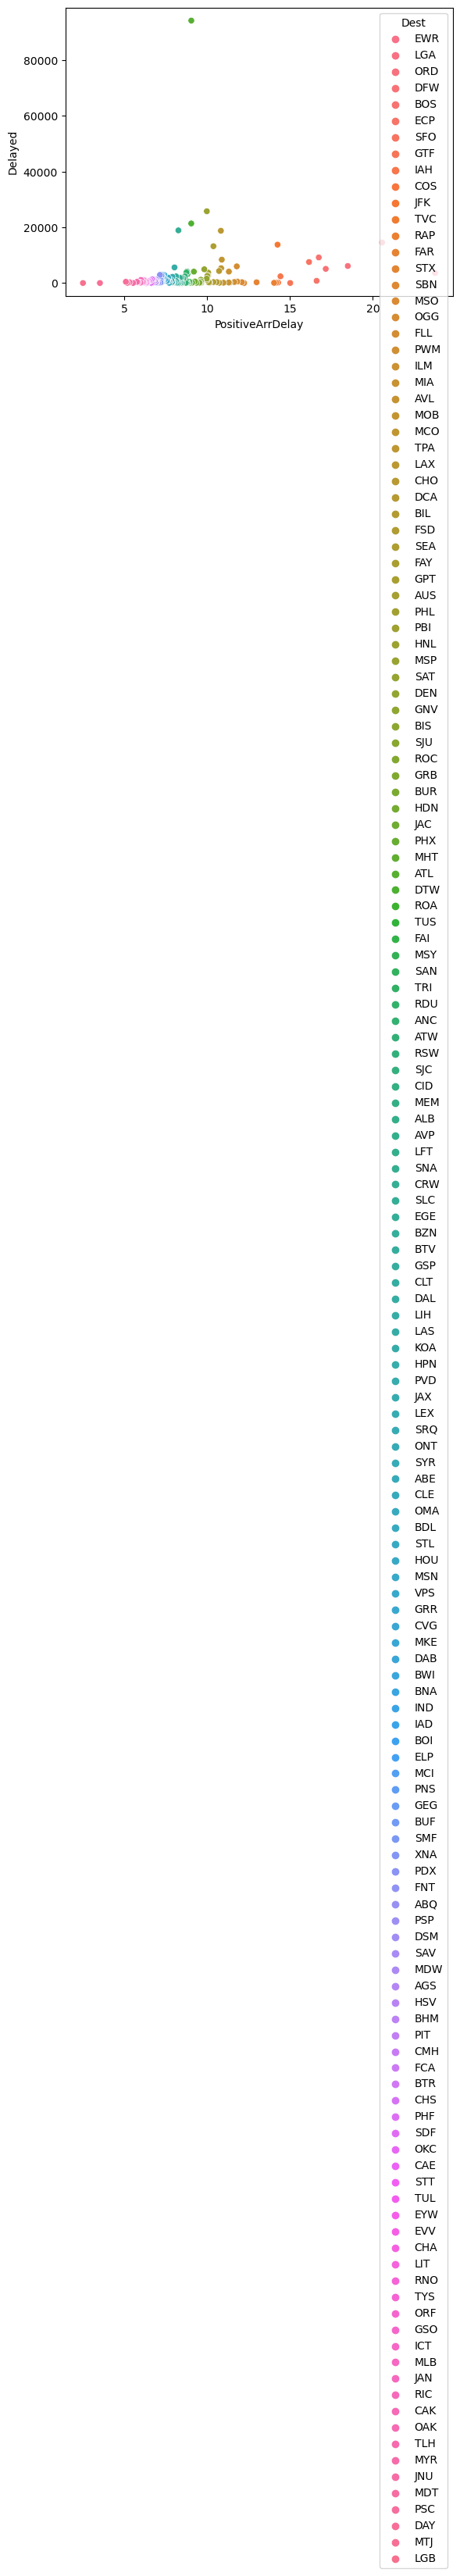

In [9]:
# compute the average delay for each value of Origin
stats2 = df.groupby("Origin").agg({"PositiveArrDelay": "mean", "Delayed":"sum"}).reset_index().sort_values(by="PositiveArrDelay", ascending=False)
# scatter plot
sns.scatterplot(x="PositiveArrDelay", y="Delayed", data=stats1, hue="Dest")

<AxesSubplot:xlabel='PositiveArrDelay', ylabel='Delayed'>

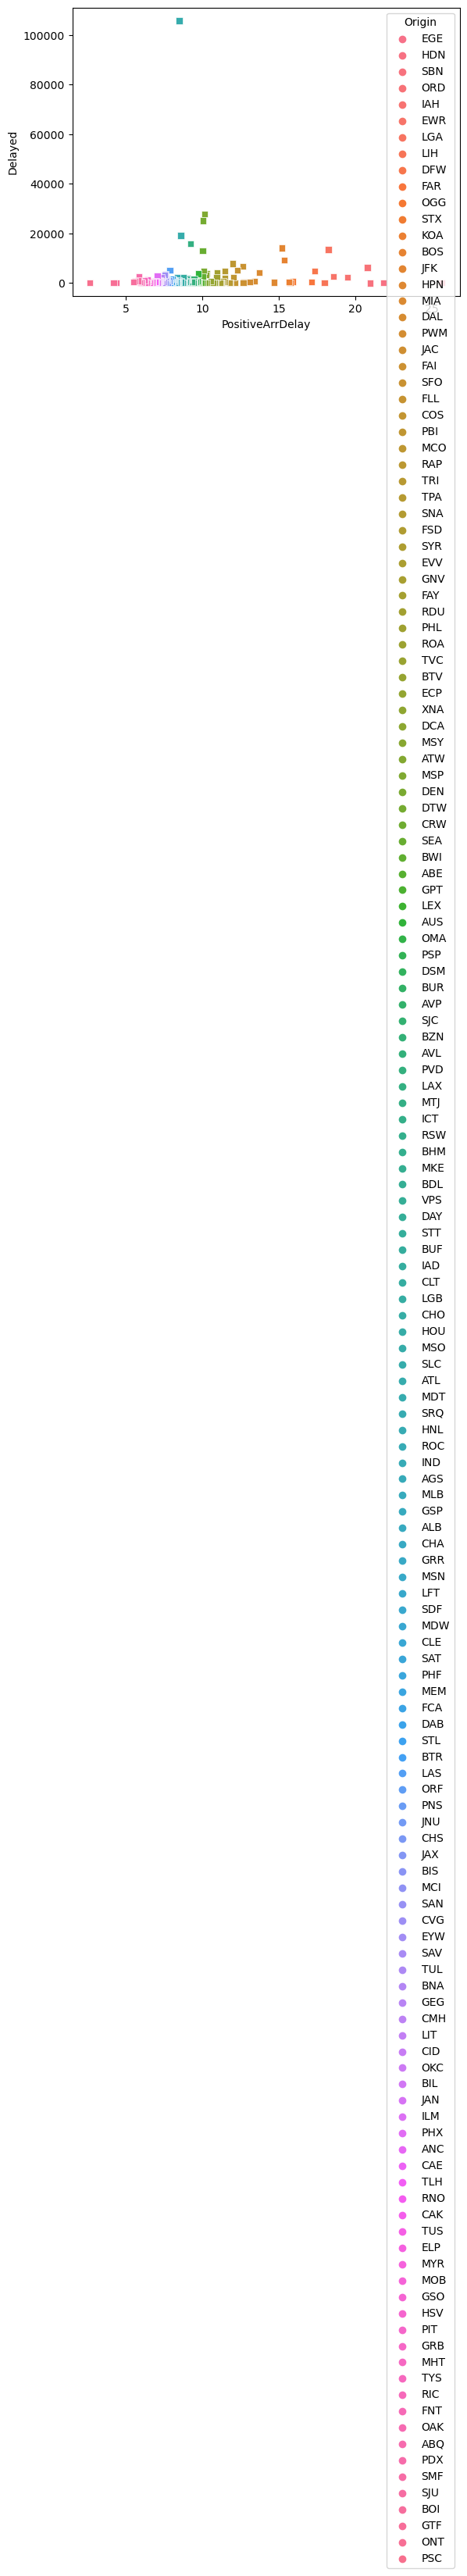

In [10]:
sns.scatterplot(x="PositiveArrDelay", y="Delayed", marker="s", data=stats2, hue="Origin")

<AxesSubplot:xlabel='PositiveArrDelay', ylabel='Delayed'>

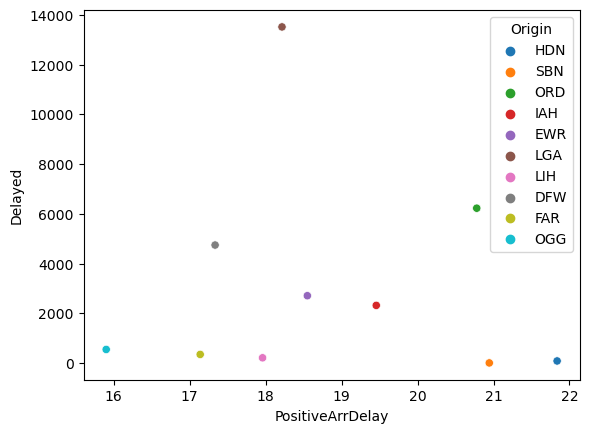

In [11]:
# compute the average delay for each value of Origin
stats1 = df[df["Origin"] != "EGE"].groupby("Origin").agg({"PositiveArrDelay": "mean", "Delayed":"sum"}).reset_index().sort_values(by="PositiveArrDelay", ascending=False).head(10)
stats2 = df.groupby("Dest").agg({"PositiveArrDelay": "mean", "Delayed":"sum"}).reset_index().sort_values(by="PositiveArrDelay", ascending=False).head(10)
# scatter plot
sns.scatterplot(x="PositiveArrDelay", y="Delayed", data=stats1, hue="Origin")

<AxesSubplot:xlabel='PositiveArrDelay', ylabel='Delayed'>

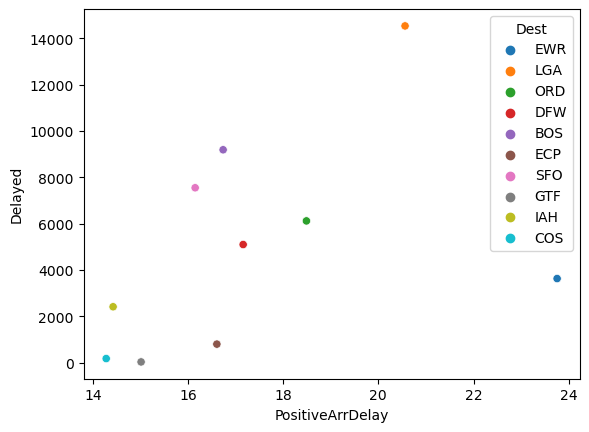

In [12]:
sns.scatterplot(x="PositiveArrDelay", y="Delayed", data=stats2, hue="Dest")

In [13]:
### Let's take LGA

In [10]:
# keep ATL flights only
df_lga = df[df["Origin"] == "LGA"]

In [11]:
len(df_lga)

39424

In [16]:
data = pd.read_csv("../data/delta_combined_flights_2018_2019_averages_regression_ready.csv")
data.head()

,FlightDate,ArrDelay,Distance,CRSDepTime,CRSElapsedTime,CRSArrTime,DayOfWeek,Year,Month,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,ATL,DTW,LAX,MSY,RDU,IAH,CLT,FLL,BNA,LGA,JAX,SLC,SEA,OAK,VPS,LIH,TLH,PHX,RIC,MCO,ORD,ABQ,OGG,MSP,PIT,CID,LIT,RSW,STL,PDX,MEM,ROA,GSP,IAD,BOS,FNT,HSV,MIA,...,SNA,ICT,KOA,BOI,BIL,SDF,BIS,AVP,SYR,MSN,SAV,MDT,GSO,RNO,EGE,TUL,XNA,COS,FAI,MHT,GPT,STT,STX,TYS,GRB,PHF,CAE,BTR,LFT,MOB,AVL,ABE,AGS,ILM,EVV,ONT,DSM,FCA,CRW,BTV,GNV,HPN,TVC,RAP,PSC,JNU,SBN,GTF,BUR,LGB
0,2018-01-01,-15.0,366.0,1205.0,82.0,1327,1,2018,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,-20.0,502.0,837.0,123.0,1040,1,2018,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,75.0,1747.0,1188.0,278.0,1326,1,2018,1,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,-14.0,1947.0,1340.0,308.0,1548,1,2018,1,0.0,0.0,0.0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,4.0,2486.0,1755.0,356.0,2151,1,2018,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# keep the rows for which LGA column is 1 or -1
data = data[(data["LGA"] == 1) | (data["LGA"] == -1)]
print(len(data))
# drop rows with CRSDepTime or CRSArrtime negative
data = data[(data["CRSDepTime"] > 0) & (data["CRSArrTime"] > 0)]
print(len(data))
data.head()

78630
78342


,FlightDate,ArrDelay,Distance,CRSDepTime,CRSElapsedTime,CRSArrTime,DayOfWeek,Year,Month,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,ATL,DTW,LAX,MSY,RDU,IAH,CLT,FLL,BNA,LGA,JAX,SLC,SEA,OAK,VPS,LIH,TLH,PHX,RIC,MCO,ORD,ABQ,OGG,MSP,PIT,CID,LIT,RSW,STL,PDX,MEM,ROA,GSP,IAD,BOS,FNT,HSV,MIA,...,SNA,ICT,KOA,BOI,BIL,SDF,BIS,AVP,SYR,MSN,SAV,MDT,GSO,RNO,EGE,TUL,XNA,COS,FAI,MHT,GPT,STT,STX,TYS,GRB,PHF,CAE,BTR,LFT,MOB,AVL,ABE,AGS,ILM,EVV,ONT,DSM,FCA,CRW,BTV,GNV,HPN,TVC,RAP,PSC,JNU,SBN,GTF,BUR,LGB
1,2018-01-01,-20.0,502.0,837.0,123.0,1040,1,2018,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,2018-01-01,18.0,1076.0,1486.0,183.0,1749,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,2018-01-01,-26.0,1096.0,905.0,209.0,1234,1,2018,1,0.0,9.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,2018-01-01,4.0,950.0,806.0,187.0,1113,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,2018-01-01,5.0,950.0,1525.0,189.0,1834,1,2018,1,0.0,4.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
len(data)

78630

In [19]:
data.to_csv("../data/delta_combined_flights_2018_2019_averages_regression_ready_lga.csv", index=False)

In [ ]:
data